In [1]:
import os

import numpy as np
import sklearn.metrics as metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import np_utils

from LoadBatch import DataGenerator 
from resnext import ResNext, ResNextImageNet
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # 不全部占满显存, 按需分配
session = tf.Session(config=config)

batch_size = 8*2
nb_classes = 1
nb_epoch = 100
weighted = True

img_rows, img_cols = 512, 512
img_channels = 3

img_dim = (img_channels, img_rows, img_cols) if K.image_dim_ordering() == "th" else (img_rows, img_cols, img_channels)
depth = [3, 4, 6, 3]
cardinality = 32
width = 4

# model = ResNextImageNet(img_dim, depth=depth, cardinality=cardinality, width=width, 
#                         weights=None, classes=nb_classes)
###################
name = 'Fracture'
###################

train_generator = DataGenerator(f'label/{name}/train/merge.txt',batch_size,norm=True)
valid_generator = DataGenerator(f'label/{name}/valid/merge.txt',batch_size,norm=True)
lines = []
with open(f'label/{name}/train/merge.txt') as f:
    train_lines = f.readlines()
    train_num = len(train_lines)
with open(f'label/{name}/valid/merge.txt') as f:
    valid_lines = f.readlines()
    valid_num = len(valid_lines)
lines = train_lines + valid_lines
if weighted:
    label = []
    for l in lines:
        x = np.array(list(map(int, l.split(' ')[1:])))
        if x==-2:
            x=np.array([0])
        #print(x)
        label.append(x)
    A = np.array(label)
    SUMPos=np.sum(A,axis=0)        # num of data examples labeled as a specific pathology class
    SUMNeg=np.sum(1-A,axis=0)
    Total=A.shape[0]               # num of data examples
    RatioPos=Total/SUMPos          # corresponding to wi1
    RatioNeg=Total/SUMNeg   
    print('-'*50)
    print(f'Total NUM:\t{Total}')
    print(RatioPos)
    print(RatioNeg)
    print(train_num, valid_num)    
    print('-'*50)  
else:
    RatioPos = np.ones((nb_classes))
    RatioNeg = np.ones((nb_classes))

/home/power/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


--------------------------------------------------
Total NUM:	520885
[34.15863335]
[1.03015806]
488663 32222
--------------------------------------------------


/home/data/DR_png/PADCHEST_SJ/image_zips/216840111366964012904401302362010335091856158_03-194-032.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient36340/study1/view1_frontal.png 1

/home/data/DR_png/MIMIC-CXR/train/p18863429/s01/view1_frontal.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient52458/study2/view1_frontal.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient42110/study9/view1_frontal.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient18426/study2/view1_frontal.png 1

/home/data/DR_png/MIMIC-CXR/train/p16549410/s01/view1_frontal.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient09422/study1/view1_frontal.png 1

/home/data/DR_png/CheXpert-v1.0/train/patient16576/study1/view1_frontal.png 1

/home/data/DR_png/PADCHEST_SJ/image_zips/67013570967741315357689497512456442311_22mij3.png 1



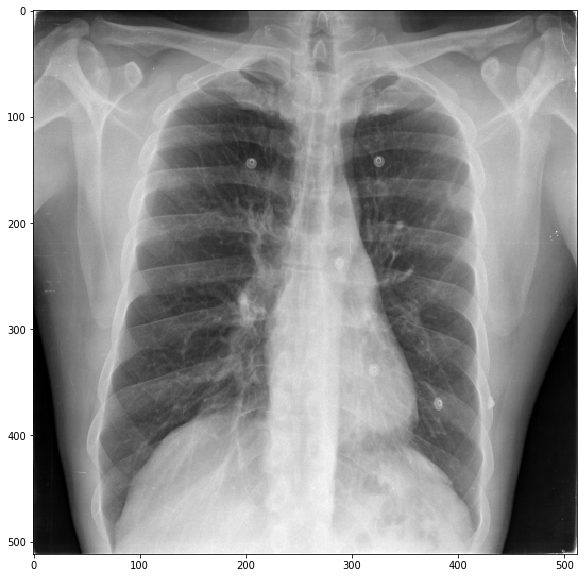

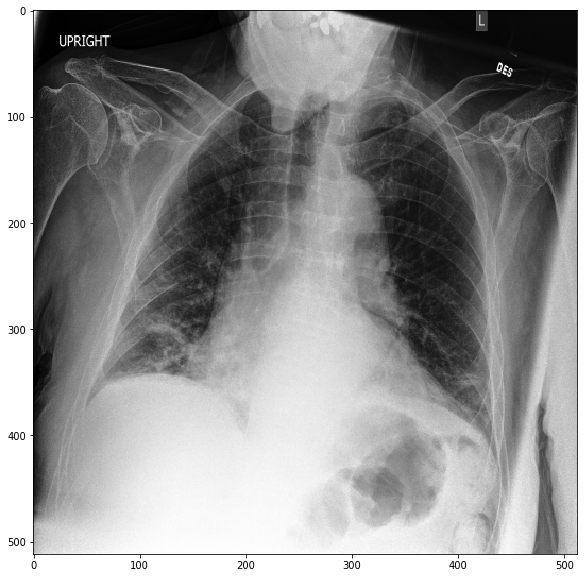

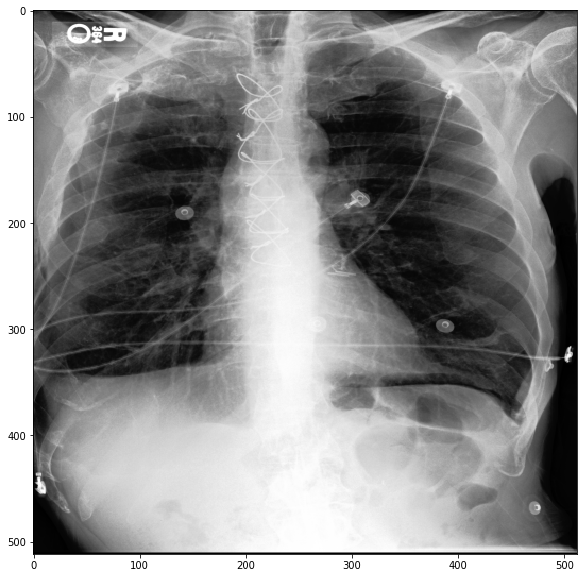

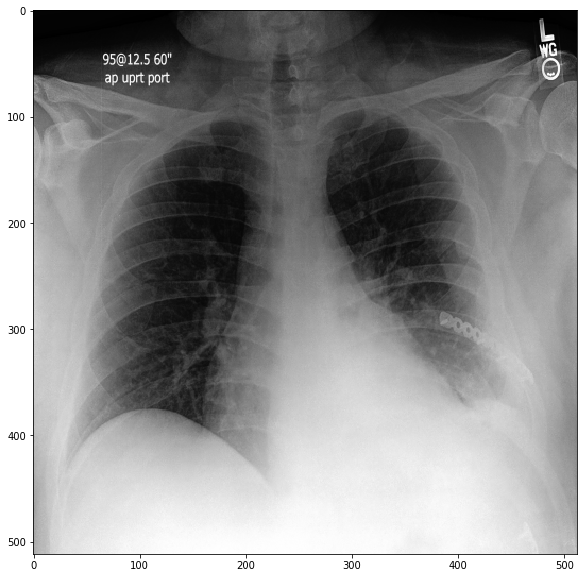

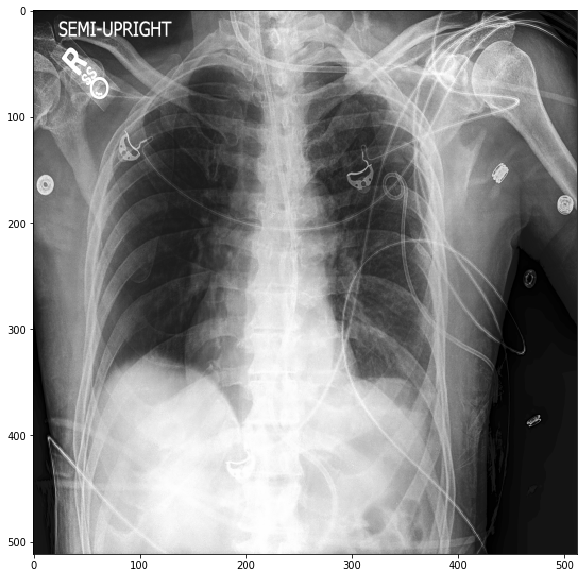

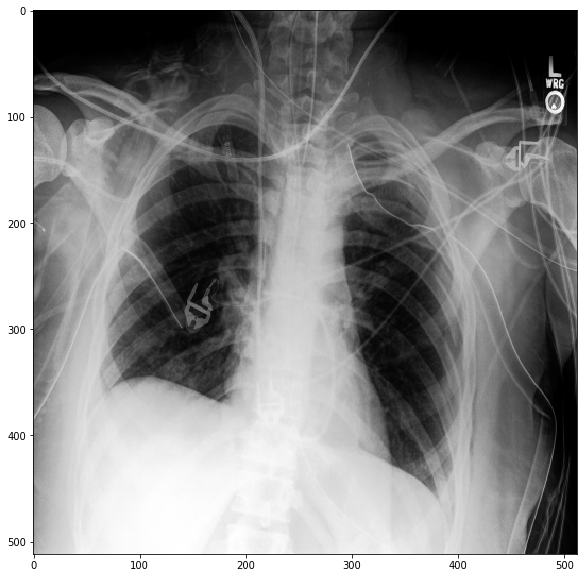

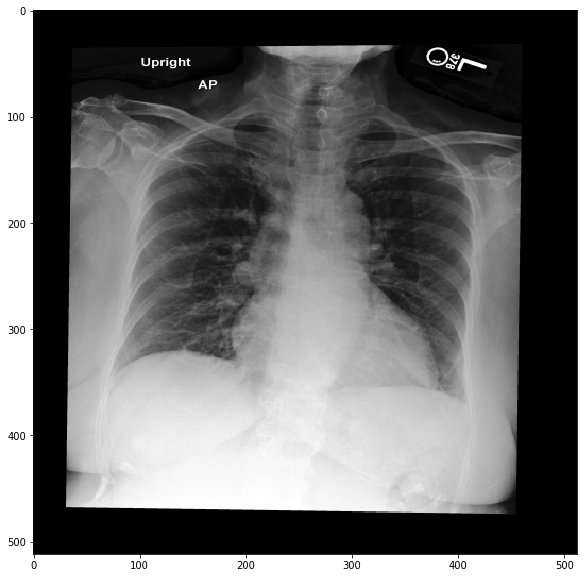

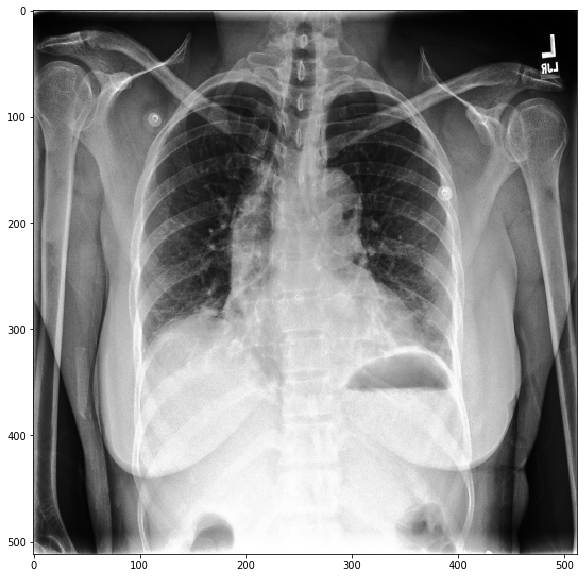

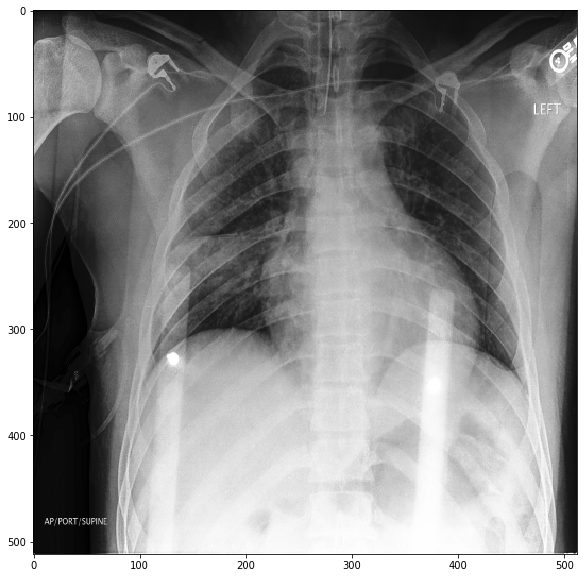

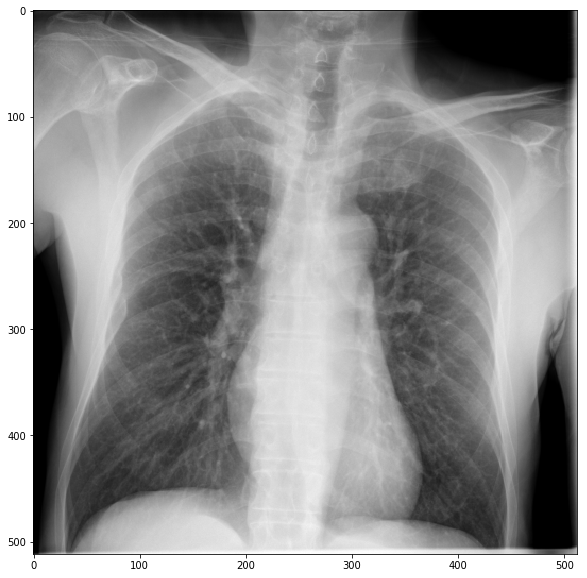

In [20]:
from LoadBatch import getimg
import matplotlib.pyplot as plt
data_path = '/home/data/DR_png/'
i=0
import random 
random.shuffle(train_lines)
for l in train_lines:
    if l[-2]=='1':
        img = getimg(data_path+l.split(' ')[0], norm=True)
        print(data_path+l)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        i+=1
    if i ==10:
        break

In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D,Dense
from keras import Model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation='sigmoid')(x)
model = Model(input=base_model.input, output=predictions)

/home/power/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [3]:
from keras.utils import multi_gpu_model
multi_model = multi_gpu_model(model, gpus=2)

In [4]:
# multi_model.load_weights('logs/Pleural Effusion/model_11-0.907.hdf5')
optimizer = Adam(1e-4)
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true[:,0], y_pred[:,0])[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
def WeightedLoss(y_true,y_pred):
    Loss=K.zeros([1])
    epsilon= 1e-5*K.ones([1]) #smooth term to avoid log0 = NaN
    for i in range(batch_size):
        for j in range(nb_classes):
            if (j == nb_classes - 1):
                Loss -= (RatioPos[j]*y_true[i,j]*K.log(y_pred[i,j]+epsilon)+RatioNeg[j]*(1-y_true[i,j])*K.log((1-y_pred[i,j])+epsilon))/(RatioPos[j]+RatioNeg[j])
            else:
                Loss -= (RatioPos[j]*y_true[i,j]*K.log(y_pred[i,j]+epsilon)+RatioNeg[j]*(1-y_true[i,j])*K.log((1-y_pred[i,j])+epsilon))/(RatioPos[j]+RatioNeg[j])
    Loss=Loss/(batch_size)    
    return Loss
if not os.path.exists('logs/'+name+'vgg16'):
    os.makedirs('logs/'+name+'vgg16')

out_path = 'logs/'+name+'vgg16/model_{epoch:02d}-{val_auc:.3f}.hdf5'
model_checkpoint2 = ModelCheckpoint(out_path, monitor="val_auc", save_best_only=False,
                                  save_weights_only=True, verbose=1)
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/tensor/'+name+'vgg16')
lr_reducer2 = ReduceLROnPlateau(monitor='val_auc', factor=np.sqrt(0.1),
                                    cooldown=0, patience=3, min_lr=1e-6)
callbacks2=[model_checkpoint2, tensorboard, lr_reducer2]
multi_model.compile(loss=WeightedLoss, optimizer=optimizer, metrics=[auc])
multi_model.fit_generator(train_generator,initial_epoch=0,
                    steps_per_epoch=train_num // batch_size//5, epochs=nb_epoch,
                    callbacks=callbacks2,
                    validation_data=valid_generator,
                    validation_steps=valid_num // batch_size, verbose=1,
                    use_multiprocessing=True, workers=5, max_queue_size=20)

/home/power/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
6108/6108 [==============================] - 2925s 479ms/step - loss: 0.2187 - auc: 0.4927 - val_loss: 0.4386 - val_auc: 0.4860

Epoch 00001: saving model to logs/Fracturevgg16/model_01-0.486.hdf5
Epoch 2/100
6108/6108 [==============================] - 2887s 473ms/step - loss: 0.3265 - auc: 0.4877 - val_loss: 0.4514 - val_auc: 0.4903

Epoch 00002: saving model to logs/Fracturevgg16/model_02-0.490.hdf5
Epoch 3/100
6108/6108 [==============================] - 2833s 464ms/step - loss: 0.3204 - auc: 0.4920 - val_loss: 0.4591 - val_auc: 0.4932

Epoch 00003: saving model to logs/Fracturevgg16/model_03-0.493.hdf5
Epoch 4/100
6108/6108 [==============================] - 2950s 483ms/step - loss: 0.3332 - auc: 0.4939 - val_loss: 0.4424 - val_auc: 0.4946

Epoch 00004: saving model to logs/Fracturevgg16/model_04-0.495.hdf5
Epoch 5/100
5619/6108 [==========================>...] - ETA: 4:53 - loss: 0.3251 - auc: 0.4952

Process ForkPoolWorker-10:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/power/anaconda3/lib/pyt

KeyboardInterrupt: 

  File "/home/power/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/power/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf

In [ ]:
!ls